**T and A**:

Proposing a scalable SVGD algorithm using multiple model fidelities:

Variants:

- randomly sample points to do low-fidelity likelihood updates and monitor convergence vs single fidelity

- In amortized SVGD, replace neural network training by models of multiple fidelities instead of approximating the likelihood function directly (constraints?)

- use some metric to intelligently decide which points will be lofi likelihood updates.

- monitor divergence of purely low-fi vs purely hi-fi SVGD

- subset simulation? Reach an EASIER posterior with low-fi simulations and then high-fi (probably Peherstorfer et al. already do this so this is not something novel) - this is _multi-level_ SVGD. - https://proceedings.mlr.press/v145/alsup22a/alsup22a.pdf


In [116]:
import numpy as np
import numpy.matlib as nm
import autograd
import torch
import os
import sys
import time
from scipy.spatial.distance import pdist, squareform
import copy

In [55]:
import matplotlib.pyplot as plt
# set dpi
plt.rcParams['figure.dpi'] = 150
plt.style.use('seaborn-v0_8-notebook')
plt.rc("font", family="serif")
plt.rc("axes.spines", top=True, right=True)
# set explicit fontsizes for ticks, lables, legend and title
plt.rc('xtick', labelsize=14)
plt.rc('ytick', labelsize=14)
plt.rc('axes', labelsize=16)
plt.rc('legend', fontsize=14, edgecolor="none", frameon=True)
plt.rc('figure', titlesize=16)

# add faint gridlines to rc settings (change grid alpha and grid linestyle )
# set grid to always be on
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 0.3
plt.rcParams['grid.linestyle'] = '--'


marker_symbol = u'\u2B2C'

In [56]:
# set random seed
np.random.seed(51)

In [172]:
from scipy.stats import qmc

n_part = 150
# sampler = qmc.Sobol(d=2, scramble=False)
# initial_particles = sampler.random(n=n_part)
initial_particles = np.random.randn(n_part, 2)

# rescale initial points to lie within -1, 1
initial_particles = 2 * initial_particles - 1

In [173]:
# now allocate particles to different distributions:
frac_particles_lf = 0.2
n_particles_lf = int(frac_particles_lf * n_part)
n_particles_hf = n_part - n_particles_lf

print(n_particles_lf, n_particles_hf)

indices_arr = np.arange(n_part)
np.random.shuffle(indices_arr)
print(indices_arr)
indices_all = indices_arr[:(n_particles_lf + n_particles_hf)]
indices_lf = indices_all[:n_particles_lf]
indices_hf = indices_all[n_particles_lf:]

indices_lf, indices_hf

30 120
[124   2 127 119 117 122 105  10  61 149 143  44  19  33 146  21  79   7
  18 138  39  55  36   9  89 136  94  81 128  91  24  34 102  35 142  87
  22  41 100  32  77  83  58   8  99 144  72  86  13  51 145 103 121  70
 134  37  95  84   1  82  38  45  92 120 108  54  29  85  97 113  78  53
  50  88  74  48  30  40 115  28  43 114 147  59  49  46  68 112   4  71
 107  56  16  63 137  96  52  57  90  42 125  47  67   3 106 111 109  12
  25  64 126  11  15 140 104  80 139 131  17  60 116   6  20  93 148  75
  76  98  66  65 110   0   5 133  26  23 101 141  14 135  69 118 132 130
  73  27 123 129  31  62]


(array([124,   2, 127, 119, 117, 122, 105,  10,  61, 149, 143,  44,  19,
         33, 146,  21,  79,   7,  18, 138,  39,  55,  36,   9,  89, 136,
         94,  81, 128,  91]),
 array([ 24,  34, 102,  35, 142,  87,  22,  41, 100,  32,  77,  83,  58,
          8,  99, 144,  72,  86,  13,  51, 145, 103, 121,  70, 134,  37,
         95,  84,   1,  82,  38,  45,  92, 120, 108,  54,  29,  85,  97,
        113,  78,  53,  50,  88,  74,  48,  30,  40, 115,  28,  43, 114,
        147,  59,  49,  46,  68, 112,   4,  71, 107,  56,  16,  63, 137,
         96,  52,  57,  90,  42, 125,  47,  67,   3, 106, 111, 109,  12,
         25,  64, 126,  11,  15, 140, 104,  80, 139, 131,  17,  60, 116,
          6,  20,  93, 148,  75,  76,  98,  66,  65, 110,   0,   5, 133,
         26,  23, 101, 141,  14, 135,  69, 118, 132, 130,  73,  27, 123,
        129,  31,  62]))

In [174]:
len(indices_lf), len(indices_hf)

(30, 120)

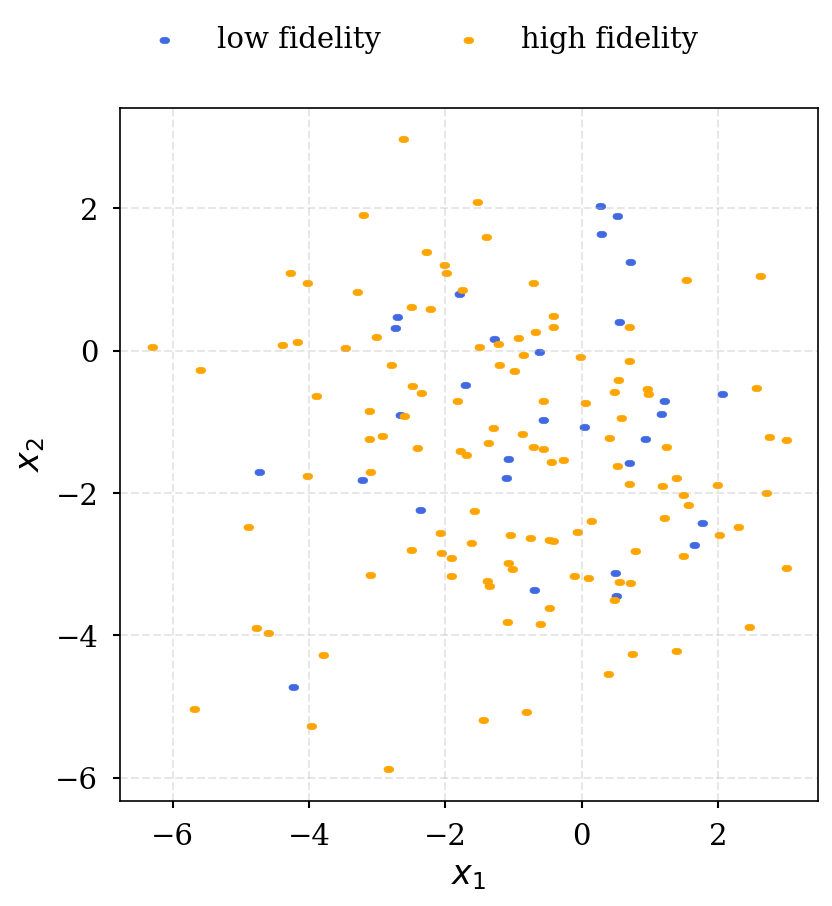

In [175]:
initial_particles_lf = initial_particles[indices_lf, :]
initial_particles_hf = initial_particles[indices_hf, :]

# plot initial particles colored by their lf-hf allocation:
fig, ax = plt.subplots(figsize=(6, 6))

ax.scatter(initial_particles_lf[:, 0], initial_particles_lf[:, 1],
            color="royalblue",
            marker="$%s$" % marker_symbol,
            s=25,
            clip_on=False,
            label="low fidelity")

ax.scatter(initial_particles_hf[:, 0], initial_particles_hf[:, 1],
            color="orange",
            marker="$%s$" % marker_symbol,
            s=25,
            clip_on=False,
            label="high fidelity")
ax.set_xlabel(r"$x_1$")
ax.set_ylabel(r"$x_2$")
fig.legend(loc="upper center", ncol=2,)

In [176]:
mu_hf = np.array([0.5, 0.2])
cov_hf = np.array([[2.0, 0.3], [0.3, 0.5]])

mu_lf = np.array([-2.5, -1.5])
cov_lf = np.array([[1.5, 0.0], [0.0, 0.5]])

def dlnprob_hf(theta, mu=mu_hf, cov=cov_hf):
    return -1*np.matmul(theta-nm.repmat(mu, theta.shape[0], 1),
                        np.linalg.inv(cov))

def dlnprob_lf(theta, mu=mu_lf, cov=cov_lf):
    return -1*np.matmul(theta-nm.repmat(mu, theta.shape[0], 1),
                        np.linalg.inv(cov))

(-3.0, 3.0)

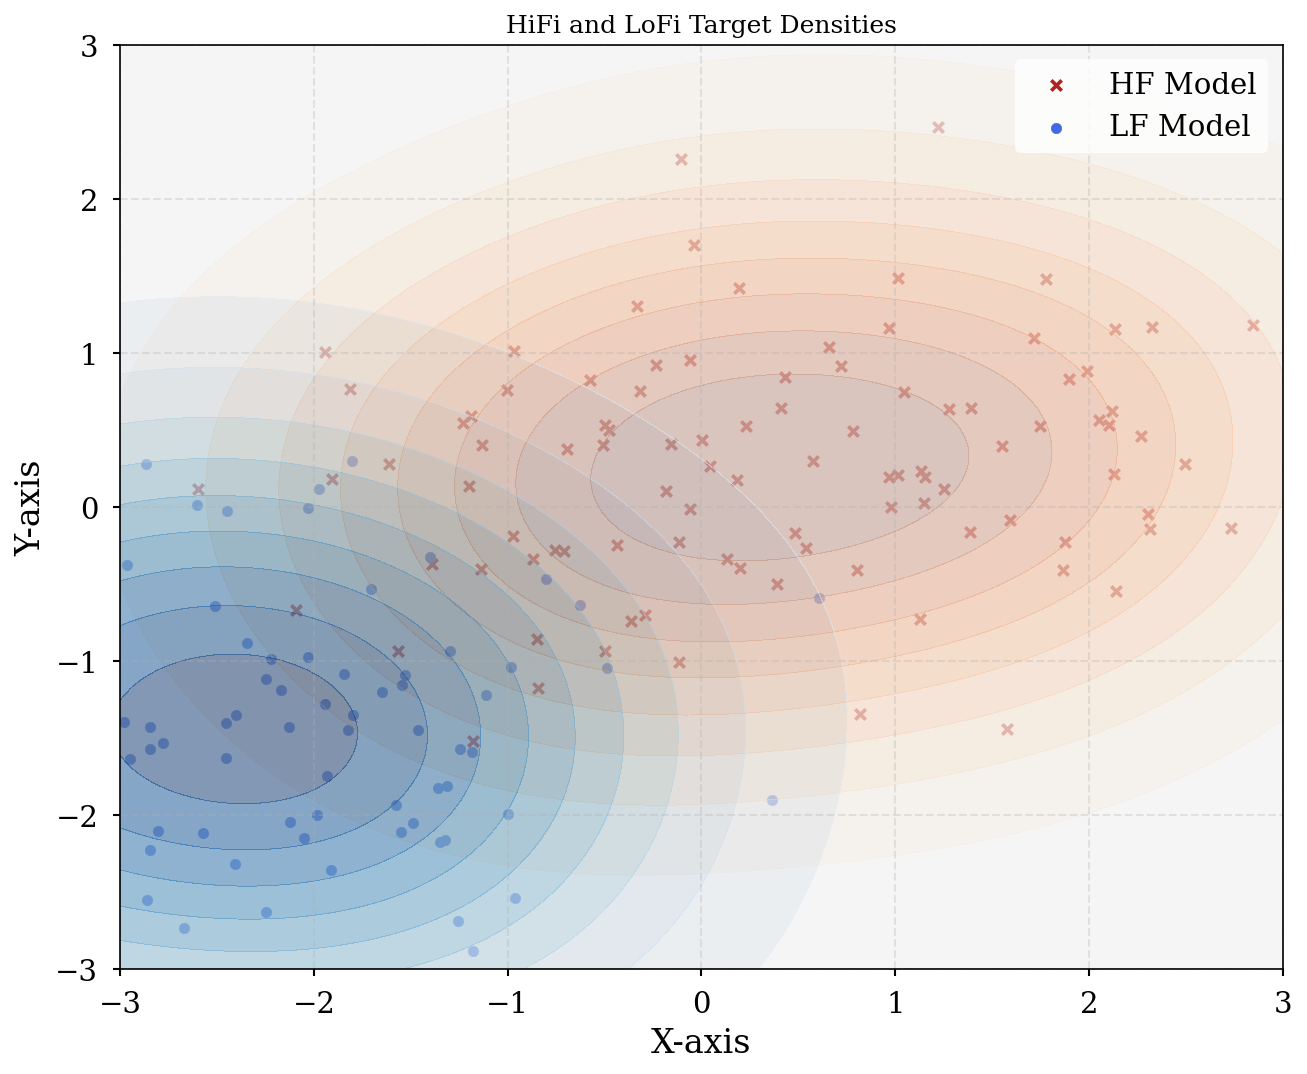

In [177]:
from sklearn.neighbors import KernelDensity
from scipy.stats import multivariate_normal

n_samples = 100

samp_hf = np.random.multivariate_normal(mu_hf, cov_hf, n_samples)
samp_lf = np.random.multivariate_normal(mu_lf, cov_lf, n_samples)

# KDE estimation for smoother contours
kde1 = KernelDensity(kernel='gaussian')
kde1.fit(samp_hf)
kde2 = KernelDensity(kernel='gaussian')
kde2.fit(samp_lf)

# Define grid for evaluation
x_min, x_max = -3, 3
y_min, y_max = -3, 3

XX, YY = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))
xy = np.vstack([XX.ravel(), YY.ravel()]).T
log_dens1 = kde1.score_samples(xy)
log_dens2 = kde2.score_samples(xy)
z1 = np.exp(log_dens1).reshape(XX.shape)
z2 = np.exp(log_dens2).reshape(XX.shape)
plt.figure(figsize=(10, 8))

plt.scatter(samp_hf[:, 0], samp_hf[:, 1],
            color='firebrick',
            marker='x',
            s=25,
            label='HF Model')
plt.scatter(samp_lf[:, 0],
            samp_lf[:, 1],
            color='royalblue',
            marker='o',
            s=25,
            label='LF Model')
plt.contourf(XX, YY, z1, levels=10, cmap='Oranges', alpha=0.5)
plt.contourf(XX, YY, z2, levels=10, cmap='Blues', alpha=0.5)
plt.legend()
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.title("HiFi and LoFi Target Densities")
plt.xlim(-3, 3)
plt.ylim(-3, 3)

If our hypothesis is correct, the low-fidelity updates minus any correction or reassignment should move further and further away from the HF posterior region. Because what we are interested in is the HF posterior. If the likelihood is misspecified so there is no overlap or in extreme cases, there is no common support for either fidelity, the particles should diverge because of the extra repulsive forces. The update may need to have some sort of correction step implicitly or explicitly, for e.g. some attractive force to counteract repulsion. Or some particle reassignment strategy.

In [178]:
class SVGD_multiple_fidelities_static():
    """
    Low-level SVGD implementation from DartML, modified to do multiple fidelity updates and
    (possibly) communicate between them! (it looks like more than anything
    that the communication is going to be the bottleneck). Also gradually realizing that the
    first term actually does not have any interaction with the LoFi (they only talk through
    repulsive forces)
    """
    def __init__(self):
        pass

    def svgd_kernel(self, theta, indices_lf, indices_hf, h = -1):
       """
       If we compute the gradient of the kernel, we can use the indices corresponding to the HF and LF particles to separate out dxkxy_lf and dxkxy_hf. 
       """
       sq_dist = pdist(theta)
       pairwise_dists = squareform(sq_dist)**2
       pairwise_lf = pairwise_dists[indices_lf, :]
       pairwise_hf = pairwise_dists[indices_hf, :]
       if h < 0:
        h_lf = np.median(pairwise_lf)
        h_lf = np.sqrt(0.5 * h_lf / np.log(len(indices_lf) + 1))
        h_hf = np.median(pairwise_hf)
        h_hf = np.sqrt(0.5 * h_hf / np.log(len(indices_hf) + 1))
    
       Kxy_lf_full = np.exp(-pairwise_dists / h_lf ** 2 / 2)
       Kxy_hf_full = np.exp(-pairwise_dists / h_hf ** 2 / 2)

       dxkxy_lf_full = -np.matmul(Kxy_lf_full, theta)
       sumkxy_lf_full = np.sum(Kxy_lf_full, axis=1)

       dxkxy_hf_full = -np.matmul(Kxy_hf_full, theta)
       sumkxy_hf_full = np.sum(Kxy_hf_full, axis=1)
       
       for i in range(theta.shape[1]):
        dxkxy_lf_full[:, i] = dxkxy_lf_full[:, i] + np.multiply(theta[:, i], sumkxy_lf_full)
        dxkxy_hf_full[:, i] = dxkxy_hf_full[:, i] + np.multiply(theta[:, i], sumkxy_hf_full)

       dxkxy_lf_full = dxkxy_lf_full / (h_lf ** 2)
       dxkxy_hf_full = dxkxy_hf_full / (h_hf ** 2)

       Kxy_lf = Kxy_lf_full[indices_lf, :]
       Kxy_hf = Kxy_hf_full[indices_hf, :]

       dxkxy_lf = dxkxy_lf_full[indices_lf, :]
       dxkxy_hf = dxkxy_hf_full[indices_hf, :]

       return Kxy_lf, dxkxy_lf, h_lf, Kxy_hf, dxkxy_hf, h_hf



    def update(self, x0, lnprob_hf,
               lnprob_lf,
               indices_hf,
               indices_lf,
               n_iters = 1000,
               stepsize = 1e-3,
               bandwidth = -1,
               alpha = 0.9,
               return_all = False,
               debug = False):
        # Check input
        if x0 is None or lnprob_lf is None or lnprob_hf is None:
            raise ValueError('x0 or lnprobs cannot be None!')

        lf_particles = x0[indices_lf, :]
        hf_particles = x0[indices_hf, :]

        theta_all_lf = np.zeros((lf_particles.shape[0], lf_particles.shape[1], n_iters))
        theta_all_hf = np.zeros((hf_particles.shape[0], hf_particles.shape[1], n_iters))


        lengthscales_all_lf = np.zeros(n_iters)
        lengthscales_all_hf = np.zeros(n_iters)
        # lengthscales_all = np.zeros(n_iters)

        theta_lf = np.copy(lf_particles)
        theta_hf = np.copy(hf_particles)

        theta_cumulative = np.copy(x0)

        n_lf = lf_particles.shape[0]
        n_hf = hf_particles.shape[0]

        # adagrad with momentum
        fudge_factor = 1e-6
        historical_grad_lf = 0
        historical_grad_hf = 0
        for iter in range(n_iters):
            if debug and (iter+1) % 1000 == 0:
                print('iter ' + str(iter+1))
            
            lnpgrad_all = np.zeros((n_lf + n_hf, x0.shape[1]))

            lnpgrad_all[indices_hf, :] = lnprob_hf(theta_hf)
            lnpgrad_all[indices_lf, :] = lnprob_lf(theta_lf)

            # calculating the kernel matrix
            kxy_lf, dxkxy_lf, h_lf, kxy_hf, dxkxy_hf, h_hf = self.svgd_kernel(theta_cumulative, indices_lf, indices_hf, h=-1)

            grad_theta_lf = (np.matmul(kxy_lf, lnpgrad_all) + dxkxy_lf) / lf_particles.shape[0]
            grad_theta_hf = (np.matmul(kxy_hf, lnpgrad_all) + dxkxy_hf) / hf_particles.shape[0]


            lengthscales_all_lf[iter] = h_lf
            lengthscales_all_hf[iter] = h_hf

            theta_cumulative = np.zeros((x0.shape[0], x0.shape[1]))

            # adagrad
            if iter == 0:
                historical_grad_lf = historical_grad_lf + grad_theta_lf ** 2
                historical_grad_hf = historical_grad_hf + grad_theta_hf ** 2
            else:
                historical_grad_lf = alpha * historical_grad_lf + (1 - alpha) * (grad_theta_lf ** 2)
                historical_grad_hf = alpha * historical_grad_hf + (1 - alpha) * (grad_theta_hf ** 2)

            adj_grad_lf = np.divide(grad_theta_lf, fudge_factor+np.sqrt(historical_grad_lf))
            adj_grad_hf = np.divide(grad_theta_hf, fudge_factor+np.sqrt(historical_grad_hf))

            theta_lf = theta_lf + stepsize * adj_grad_lf
            theta_hf = theta_hf + stepsize * adj_grad_hf

            theta_all_lf[:, :, iter] = theta_lf
            theta_all_hf[:, :, iter] = theta_hf

            theta_cumulative[indices_lf, :] = theta_lf
            theta_cumulative[indices_hf, :] = theta_hf

        if return_all:
          return theta_all_hf, theta_all_lf, lengthscales_all_hf, lengthscales_all_lf
        else:
          return theta_all_hf, theta_all_lf

In [179]:
class SVGD_multiple_fidelities_dynamic():
    """
    Low-level SVGD implementation from DartML, modified to do multiple fidelity updates and
    (possibly) communicate between them! (it looks like more than anything
    that the communication is going to be the bottleneck). Also gradually realizing that the
    first term actually does not have any interaction with the LoFi (they only talk through
    repulsive forces)
    """
    def __init__(self):
        pass

    def svgd_kernel(self, theta, indices_lf, indices_hf, h = -1):
       """
       If we compute the gradient of the kernel, we can use the indices corresponding to the HF and LF particles to separate out dxkxy_lf and dxkxy_hf. 
       """
       sq_dist = pdist(theta)
       pairwise_dists = squareform(sq_dist)**2
       pairwise_lf = pairwise_dists[indices_lf, :]
       pairwise_hf = pairwise_dists[indices_hf, :]
       if h < 0:
        h_lf = np.median(pairwise_lf)
        h_lf = np.sqrt(0.5 * h_lf / np.log(len(indices_lf) + 1))
        h_hf = np.median(pairwise_hf)
        h_hf = np.sqrt(0.5 * h_hf / np.log(len(indices_hf) + 1))
    
       Kxy_lf_full = np.exp(-pairwise_dists / h_lf ** 2 / 2)
       Kxy_hf_full = np.exp(-pairwise_dists / h_hf ** 2 / 2)

       dxkxy_lf_full = -np.matmul(Kxy_lf_full, theta)
       sumkxy_lf_full = np.sum(Kxy_lf_full, axis=1)

       dxkxy_hf_full = -np.matmul(Kxy_hf_full, theta)
       sumkxy_hf_full = np.sum(Kxy_hf_full, axis=1)
       
       for i in range(theta.shape[1]):
        dxkxy_lf_full[:, i] = dxkxy_lf_full[:, i] + np.multiply(theta[:, i], sumkxy_lf_full)
        dxkxy_hf_full[:, i] = dxkxy_hf_full[:, i] + np.multiply(theta[:, i], sumkxy_hf_full)

       dxkxy_lf_full = dxkxy_lf_full / (h_lf ** 2)
       dxkxy_hf_full = dxkxy_hf_full / (h_hf ** 2)

       Kxy_lf = Kxy_lf_full[indices_lf, :]
       Kxy_hf = Kxy_hf_full[indices_hf, :]

       dxkxy_lf = dxkxy_lf_full[indices_lf, :]
       dxkxy_hf = dxkxy_hf_full[indices_hf, :]

       return Kxy_lf, dxkxy_lf, h_lf, Kxy_hf, dxkxy_hf, h_hf



    def update(self, x0, lnprob_hf,
               lnprob_lf,
               indices_hf,
               indices_lf,
               n_iters = 1000,
               stepsize = 1e-3,
               bandwidth = -1,
               alpha = 0.9,
               return_all = False,
               debug = False):
        # Check input
        if x0 is None or lnprob_lf is None or lnprob_hf is None:
            raise ValueError('x0 or lnprobs cannot be None!')

        lf_particles = x0[indices_lf, :]
        hf_particles = x0[indices_hf, :]

        theta_all_lf = np.zeros((lf_particles.shape[0], lf_particles.shape[1], n_iters))
        theta_all_hf = np.zeros((hf_particles.shape[0], hf_particles.shape[1], n_iters))


        lengthscales_all_lf = np.zeros(n_iters)
        lengthscales_all_hf = np.zeros(n_iters)
        # lengthscales_all = np.zeros(n_iters)

        theta_lf = np.copy(lf_particles)
        theta_hf = np.copy(hf_particles)

        theta_cumulative = np.copy(x0)

        n_lf = lf_particles.shape[0]
        n_hf = hf_particles.shape[0]

        n_part = n_lf + n_hf

        # adagrad with momentum
        fudge_factor = 1e-6
        historical_grad_lf = 0
        historical_grad_hf = 0

        idx_lf_new = copy.deepcopy(indices_lf)
        idx_hf_new = copy.deepcopy(indices_hf)


        for iter in range(n_iters):
            if debug and (iter+1) % 1000 == 0:
                print('iter ' + str(iter+1))
            
            lnpgrad_all = np.zeros((n_lf + n_hf, x0.shape[1]))

            lnpgrad_all[idx_hf_new, :] = lnprob_hf(theta_hf)
            lnpgrad_all[idx_lf_new, :] = lnprob_lf(theta_lf)

            # calculating the kernel matrix
            kxy_lf, dxkxy_lf, h_lf, kxy_hf, dxkxy_hf, h_hf = self.svgd_kernel(theta_cumulative, idx_lf_new, idx_hf_new, h=-1)


            grad_theta_lf = (np.matmul(kxy_lf, lnpgrad_all) + dxkxy_lf) / lf_particles.shape[0]
            grad_theta_hf = (np.matmul(kxy_hf, lnpgrad_all) + dxkxy_hf) / hf_particles.shape[0]


            lengthscales_all_lf[iter] = h_lf
            lengthscales_all_hf[iter] = h_hf

            theta_cumulative = np.zeros((x0.shape[0], x0.shape[1]))

            # adagrad
            if iter == 0:
                historical_grad_lf = historical_grad_lf + grad_theta_lf ** 2
                historical_grad_hf = historical_grad_hf + grad_theta_hf ** 2
            else:
                historical_grad_lf = alpha * historical_grad_lf + (1 - alpha) * (grad_theta_lf ** 2)
                historical_grad_hf = alpha * historical_grad_hf + (1 - alpha) * (grad_theta_hf ** 2)

            adj_grad_lf = np.divide(grad_theta_lf, fudge_factor+np.sqrt(historical_grad_lf))
            adj_grad_hf = np.divide(grad_theta_hf, fudge_factor+np.sqrt(historical_grad_hf))

            theta_lf = theta_lf + stepsize * adj_grad_lf
            theta_hf = theta_hf + stepsize * adj_grad_hf

            theta_all_lf[:, :, iter] = theta_lf
            theta_all_hf[:, :, iter] = theta_hf

            theta_cumulative[idx_lf_new, :] = theta_lf
            theta_cumulative[idx_hf_new, :] = theta_hf

            # shuffle the particles.
            indices_arr = np.arange(n_part)
            np.random.shuffle(indices_arr)
            indices_all = indices_arr[:(n_particles_lf + n_particles_hf)]
            idx_lf_new = indices_all[:n_particles_lf]
            idx_hf_new = indices_all[n_particles_lf:]

        if return_all:
          return theta_all_hf, theta_all_lf, lengthscales_all_hf, lengthscales_all_lf
        else:
          return theta_all_hf, theta_all_lf

In [180]:
theta_all_hf, theta_all_lf, h_hf_all, h_lf_all = SVGD_multiple_fidelities_static().update(initial_particles,
                                dlnprob_hf,
                                dlnprob_lf,
                                indices_hf,
                                indices_lf,
                                n_iters=1000,
                                return_all=True)                                                         

In [181]:
theta_all_hf2, theta_all_lf2, h_hf_all2, h_lf_all2 = SVGD_multiple_fidelities_dynamic().update(initial_particles,
                                dlnprob_hf,
                                dlnprob_lf,
                                indices_hf,
                                indices_lf,
                                n_iters=1000,
                                return_all=True)    

(-4.0, 4.0)

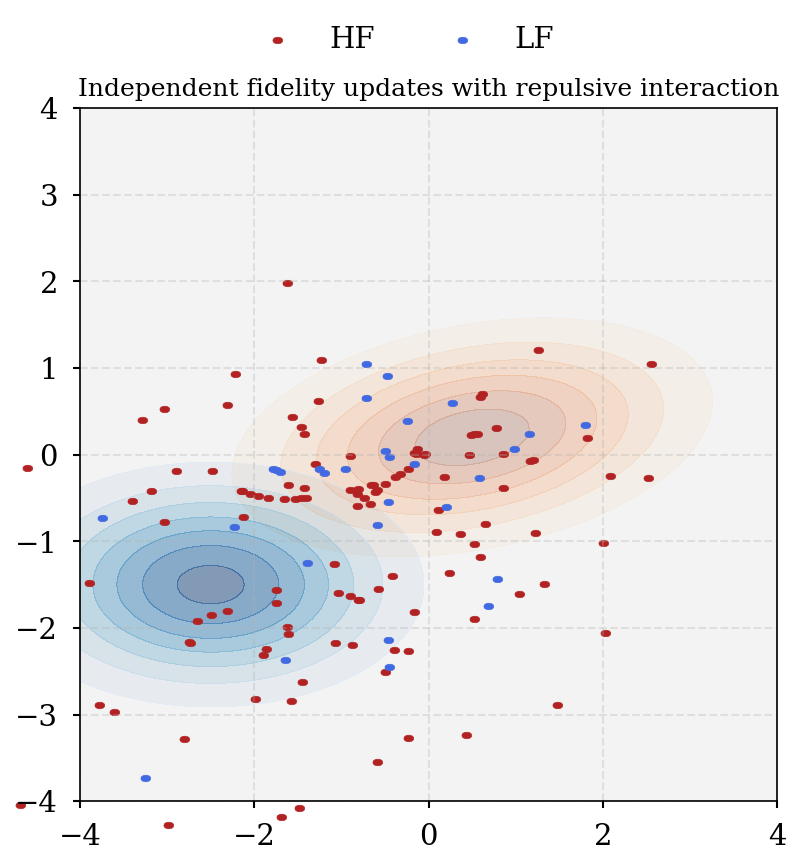

In [192]:
x, y = np.mgrid[-4:4:.01, -4:4:.01]
pos = np.dstack((x, y))

rv_hf = multivariate_normal(mu_hf, cov_hf)
rv_lf = multivariate_normal(mu_lf, cov_lf)

fig2 = plt.figure(figsize=(6, 6))
ax2 = fig2.add_subplot(111)
ax2.contourf(x, y,
             rv_hf.pdf(pos),
             alpha=0.5,
             cmap='Oranges')

ax2.contourf(x, y,
            rv_lf.pdf(pos),
            alpha=0.5,
            cmap='Blues')

marker_symbol = u'\u2B2C'

# Scatter initial particles
ax2.scatter(theta_all_hf[:, 0, -1], theta_all_hf[:, 1, -1],
            color="firebrick",
            marker="$%s$" % marker_symbol,
            s=25,
            clip_on=False,
            label="HF")

ax2.scatter(theta_all_lf[:, 0, -1], theta_all_lf[:, 1, -1],
            color="royalblue",
            marker="$%s$" % marker_symbol,
            s=25,
            clip_on=False,
            label="LF")


fig2.legend(loc="upper center", ncol=2,)
ax2.set_title("Independent fidelity updates with repulsive interaction")
ax2.set_xlim(-4, 4)
ax2.set_ylim(-4, 4)

(-4.0, 4.0)

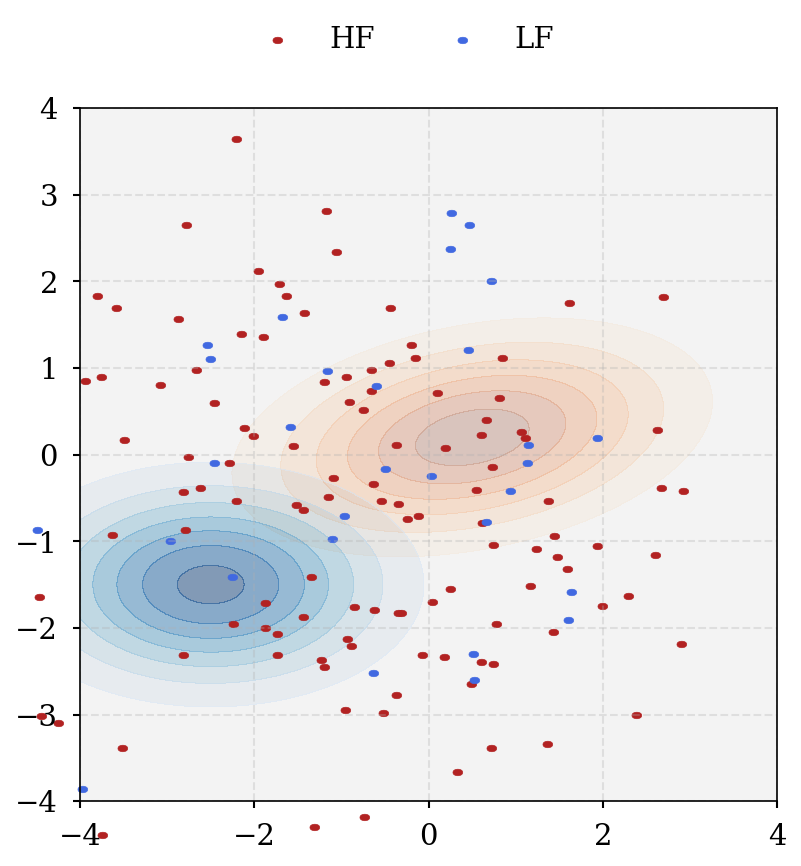

In [183]:
x, y = np.mgrid[-4:4:.01, -4:4:.01]
pos = np.dstack((x, y))

rv_hf = multivariate_normal(mu_hf, cov_hf)
rv_lf = multivariate_normal(mu_lf, cov_lf)

fig2 = plt.figure(figsize=(6, 6))
ax2 = fig2.add_subplot(111)
ax2.contourf(x, y,
             rv_hf.pdf(pos),
             alpha=0.5,
             cmap='Oranges')

ax2.contourf(x, y,
            rv_lf.pdf(pos),
            alpha=0.5,
            cmap='Blues')

marker_symbol = u'\u2B2C'

# Scatter initial particles
ax2.scatter(theta_all_hf2[:, 0, -1], theta_all_hf2[:, 1, -1],
            color="firebrick",
            marker="$%s$" % marker_symbol,
            s=25,
            clip_on=False,
            label="HF")

ax2.scatter(theta_all_lf2[:, 0, -1], theta_all_lf2[:, 1, -1],
            color="royalblue",
            marker="$%s$" % marker_symbol,
            s=25,
            clip_on=False,
            label="LF")


fig2.legend(loc="upper center", ncol=2,)

ax2.set_xlim(-4, 4)
ax2.set_ylim(-4, 4)

Text(0, 0.5, 'lengthscale')

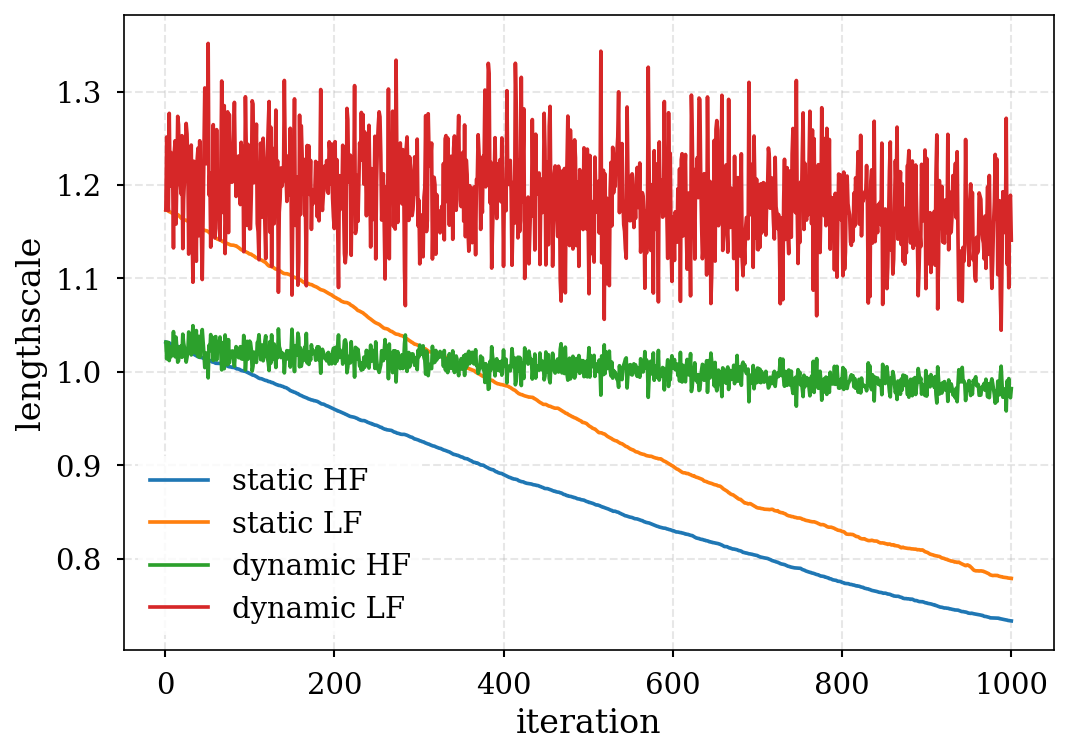

In [184]:
n_iters = 1000
plt.plot(np.linspace(1, n_iters, n_iters), h_hf_all, label="static HF")
plt.plot(np.linspace(1, n_iters, n_iters), h_lf_all, label="static LF")
plt.plot(np.linspace(1, n_iters, n_iters), h_hf_all2, label="dynamic HF")
plt.plot(np.linspace(1, n_iters, n_iters), h_lf_all2, label="dynamic LF")
plt.legend()
plt.xlabel("iteration")
plt.ylabel("lengthscale")

In [185]:
class SVGD_multiple_fidelities_bifidelity():
    """
    Low-fidelity likelihood gradient + correction term (for now, subtract log likelihoods at the high-fidelity points, all other terms remaining unchanged. Ideally we will write e^(f(x, theta)), get rid of the Z normalizing term, and do subtractions for f_LF and f_HF before computing the delta log likelihoods)
    """
    def __init__(self):
        pass

    def svgd_kernel(self, theta, h = -1):
       """
       If we compute the gradient of the kernel, we can use the indices corresponding to the HF and LF particles to separate out dxkxy_lf and dxkxy_hf. 
       """
       sq_dist = pdist(theta)
       pairwise_dists = squareform(sq_dist)**2
       if h < 0:
        # h_lf = np.median(pairwise_lf)
        # h_lf = np.sqrt(0.5 * h_lf / np.log(len(indices_lf) + 1))
        # h_hf = np.median(pairwise_hf)
        # h_hf = np.sqrt(0.5 * h_hf / np.log(len(indices_hf) + 1))
        h = np.median(pairwise_dists)
        h = np.sqrt(0.5 * h / np.log(len(theta) + 1))
    
       Kxy_full = np.exp(-pairwise_dists / h ** 2 / 2)       
       dxkxy_full = -np.matmul(Kxy_full, theta)
       sumkxy_full = np.sum(Kxy_full, axis=1)

       for i in range(theta.shape[1]):
        dxkxy_full[:, i] = dxkxy_full[:, i] + np.multiply(theta[:, i], sumkxy_full)
       dxkxy_full = dxkxy_full / (h ** 2)
       return Kxy_full, dxkxy_full, h



    def update(self, x0, lnprob_hf,
               lnprob_lf,
               indices_hf,
               indices_lf,
               n_iters = 1000,
               stepsize = 1e-3,
               bandwidth = -1,
               alpha = 0.9,
               return_all = False,
               shuffle=False,
               debug = False):
        # Check input
        if x0 is None or lnprob_lf is None or lnprob_hf is None:
            raise ValueError('x0 or lnprobs cannot be None!')

        lf_particles = x0[indices_lf, :]
        hf_particles = x0[indices_hf, :]

        theta_all = np.zeros((x0.shape[0], x0.shape[1], n_iters))

        lengthscales_all = np.zeros(n_iters)

        theta_lf = np.copy(lf_particles)
        theta_hf = np.copy(hf_particles)

        theta_cumulative = np.copy(x0)

        n_lf = lf_particles.shape[0]
        n_hf = hf_particles.shape[0]

        n_part = n_lf + n_hf

        # adagrad with momentum
        fudge_factor = 1e-6
        historical_grad = 0

        idx_lf_new = copy.deepcopy(indices_lf)
        idx_hf_new = copy.deepcopy(indices_hf)



        for iter in range(n_iters):
            if debug and (iter+1) % 1000 == 0:
                print('iter ' + str(iter+1))
            
            lnpgrad_all = np.zeros((n_lf + n_hf, x0.shape[1]))

            # lnpgrad_all[idx_hf_new, :] = lnprob_hf(theta_hf)
            lnpgrad_all[idx_lf_new, :] = lnprob_lf(theta_lf)
            lnpgrad_all[idx_hf_new, :] = lnprob_hf(theta_hf) - lnprob_lf(theta_hf)


            # calculating the kernel matrix
            kxy, dxkxy, hls = self.svgd_kernel(theta_cumulative, h=-1)


            grad_theta = (np.matmul(kxy, lnpgrad_all) + dxkxy) / theta_cumulative.shape[0]

            lengthscales_all[iter] = hls

            # theta_cumulative = np.zeros((x0.shape[0], x0.shape[1]))

            # adagrad
            if iter == 0:
                historical_grad = historical_grad + grad_theta ** 2
            else:
                historical_grad = alpha * historical_grad + (1 - alpha) * (grad_theta ** 2)

            adj_grad = np.divide(grad_theta, fudge_factor+np.sqrt(historical_grad))

            theta_cumulative = theta_cumulative + stepsize * adj_grad

            theta_all[:, :, iter] = theta_cumulative

            # shuffle the particles.
            if shuffle:
                indices_arr = np.arange(n_part)
                np.random.shuffle(indices_arr)
                indices_all = indices_arr[:(n_particles_lf + n_particles_hf)]
                idx_lf_new = indices_all[:n_particles_lf]
                idx_hf_new = indices_all[n_particles_lf:]

        if return_all:
          return theta_all, lengthscales_all
        else:
          return theta_all

In [186]:
theta_all_3, h_all_3 = SVGD_multiple_fidelities_bifidelity().update(initial_particles,
                                dlnprob_hf,
                                dlnprob_lf,
                                indices_hf,
                                indices_lf,
                                n_iters=1000,
                                return_all=True,
                                shuffle=False
                                ) 

(-4.0, 4.0)

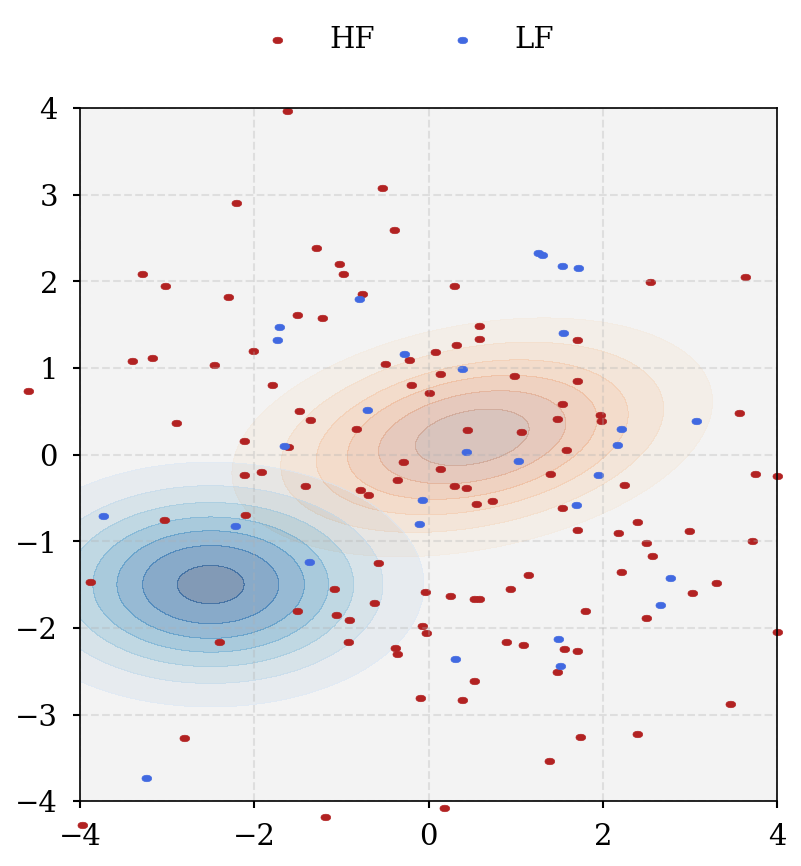

In [187]:
x, y = np.mgrid[-4:4:.01, -4:4:.01]
pos = np.dstack((x, y))

rv_hf = multivariate_normal(mu_hf, cov_hf)
rv_lf = multivariate_normal(mu_lf, cov_lf)

fig2 = plt.figure(figsize=(6, 6))
ax2 = fig2.add_subplot(111)
ax2.contourf(x, y,
             rv_hf.pdf(pos),
             alpha=0.5,
             cmap='Oranges')

ax2.contourf(x, y,
            rv_lf.pdf(pos),
            alpha=0.5,
            cmap='Blues')


# Scatter initial particles
ax2.scatter(theta_all_3[indices_hf, 0, -1], theta_all_3[indices_hf, 1, -1],
            color="firebrick",
            marker="$%s$" % marker_symbol,
            s=25,
            clip_on=False,
            label="HF")

ax2.scatter(theta_all_3[indices_lf, 0, -1], theta_all_3[indices_lf, 1, -1],
            color="royalblue",
            marker="$%s$" % marker_symbol,
            s=25,
            clip_on=False,
            label="LF")

fig2.legend(loc="upper center", ncol=2,)

ax2.set_xlim(-4, 4)
ax2.set_ylim(-4, 4)

Text(0, 0.5, 'lengthscale')

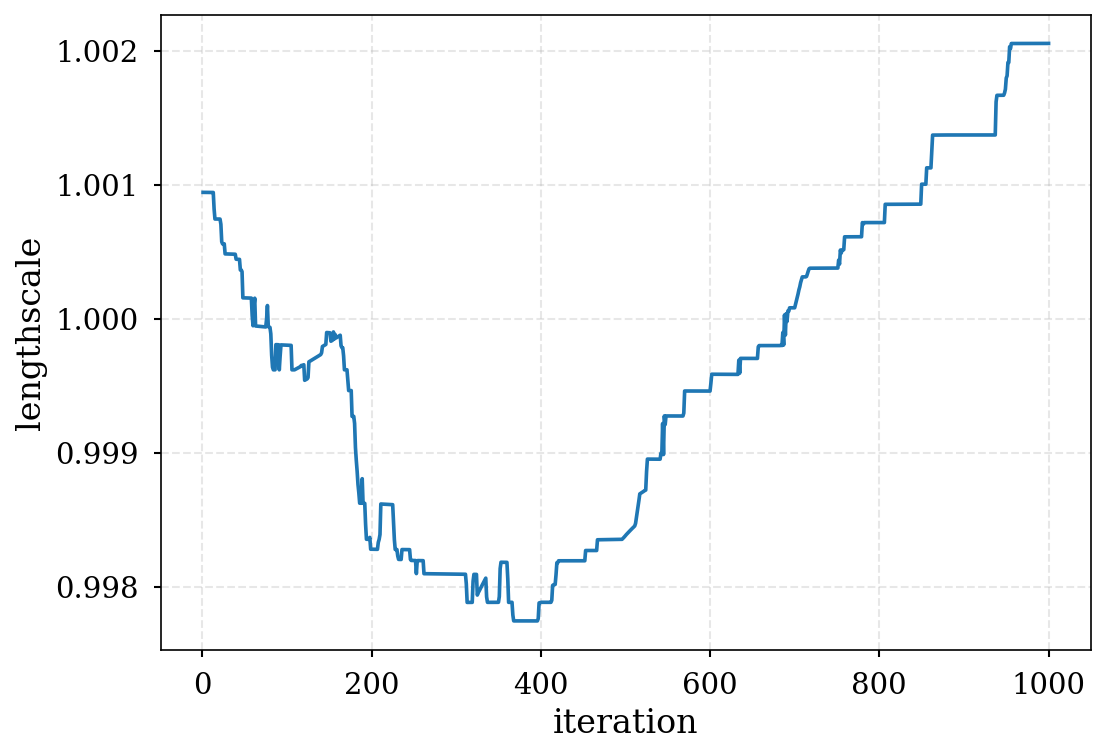

In [188]:
n_iters = 1000
plt.plot(np.linspace(1, n_iters, n_iters), h_all_3, label="lengthscale cumulative")
plt.xlabel("iteration")
plt.ylabel("lengthscale")

In [189]:
theta_all_4, h_all_4 = SVGD_multiple_fidelities_bifidelity().update(initial_particles,
                                dlnprob_hf,
                                dlnprob_lf,
                                indices_hf,
                                indices_lf,
                                n_iters=1000,
                                return_all=True,
                                shuffle=True
                                ) 

(-4.0, 4.0)

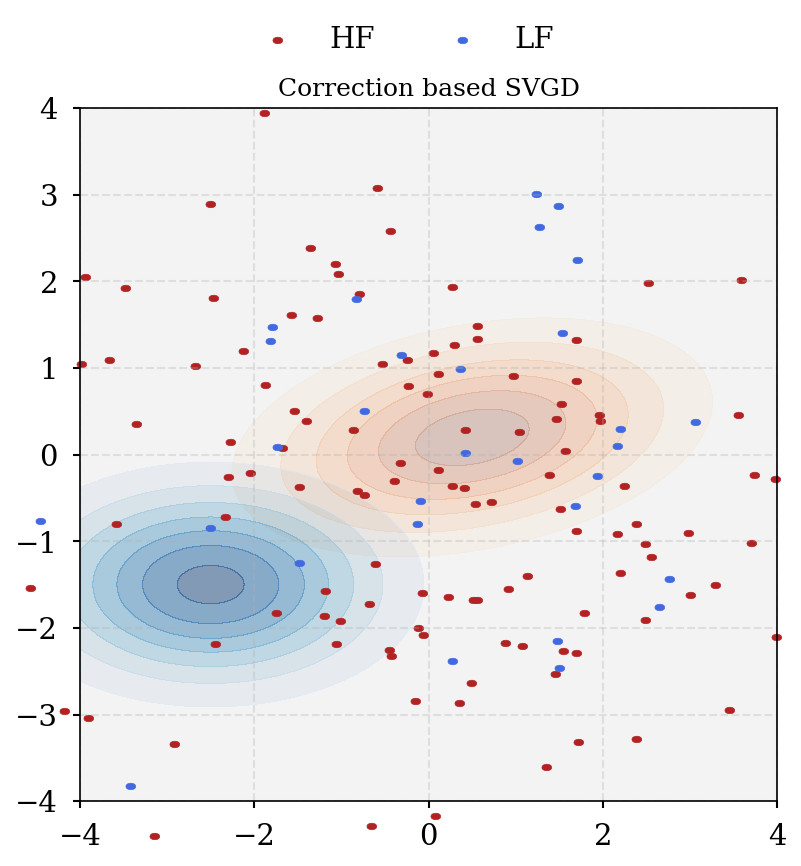

In [193]:
x, y = np.mgrid[-4:4:.01, -4:4:.01]
pos = np.dstack((x, y))

rv_hf = multivariate_normal(mu_hf, cov_hf)
rv_lf = multivariate_normal(mu_lf, cov_lf)

fig2 = plt.figure(figsize=(6, 6))
ax2 = fig2.add_subplot(111)
ax2.contourf(x, y,
             rv_hf.pdf(pos),
             alpha=0.5,
             cmap='Oranges')

ax2.contourf(x, y,
            rv_lf.pdf(pos),
            alpha=0.5,
            cmap='Blues')


# Scatter initial particles
ax2.scatter(theta_all_4[indices_hf, 0, -1], theta_all_4[indices_hf, 1, -1],
            color="firebrick",
            marker="$%s$" % marker_symbol,
            s=25,
            clip_on=False,
            label="HF")

ax2.scatter(theta_all_4[indices_lf, 0, -1], theta_all_4[indices_lf, 1, -1],
            color="royalblue",
            marker="$%s$" % marker_symbol,
            s=25,
            clip_on=False,
            label="LF")

fig2.legend(loc="upper center", ncol=2,)
ax2.set_title("Correction based SVGD")
ax2.set_xlim(-4, 4)
ax2.set_ylim(-4, 4)

Text(0, 0.5, 'lengthscale')

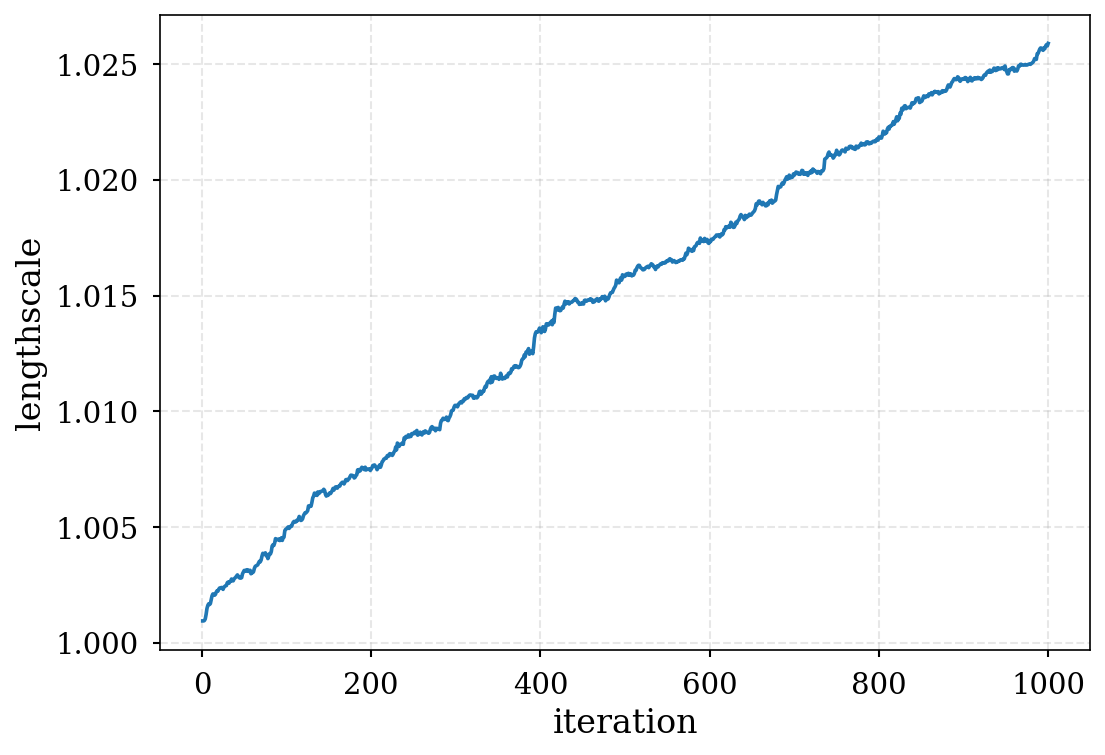

In [191]:
n_iters = 1000
plt.plot(np.linspace(1, n_iters, n_iters), h_all_4, label="lengthscale cumulative")
plt.xlabel("iteration")
plt.ylabel("lengthscale")